<a href="https://colab.research.google.com/github/bysischpok/ML-final-project/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Импорт всех необходимых библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from imblearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings("ignore")

#Создаем функцию для добавления новых признаков в наш датасет.

In [ ]:
def add_features(df):
    df['length'] = df['password'].apply(len)
    df['special_chars'] = df['password'].apply(lambda x: len(re.findall(r'[\W]', x)))
    df['uppercase'] = df['password'].apply(lambda x: len(re.findall(r'[A-Z]', x)))
    df['lowercase'] = df['password'].apply(lambda x: len(re.findall(r'[a-z]', x)))
    df['digits'] = df['password'].apply(lambda x: len(re.findall(r'[0-9]', x)))

    # Максимальная длина последовательных символов одной категории
    def max_sequence_length(password):
        max_length = 0
        current_length = 1

        for i in range(1, len(password)):
            if (password[i].islower() and password[i-1].islower()) or \
               (password[i].isupper() and password[i-1].isupper()) or \
               (password[i].isdigit() and password[i-1].isdigit()) or \
               (not password[i].isalnum() and not password[i-1].isalnum()):
                current_length += 1
            else:
                max_length = max(max_length, current_length)
                current_length = 1

        max_length = max(max_length, current_length)  # Проверка на конец строки
        return max_length

    df['max_consecutive'] = df['password'].apply(max_sequence_length)

    def unique_chars(password):
        # Находим уникальные символы
        unique_characters = set(password)
        # Вычисляем соотношение уникальных символов к общему количеству символов
        uniq = len(unique_characters) / len(password)
        return uniq
    df['uniq_chars_%'] = df['password'].apply(unique_chars)

    #Загружаем список популярных паролей и сравниваем с нашими из датасета
    with open('worst_passwords.txt', 'r') as file:
        typical_passwords = {line.strip() for line in file}

    #Проверяем, является ли пароль популярным
    df['pass_is_popular?'] = df['password'].apply(lambda x: 1 if x in typical_passwords else 0)
    return df


#Загружаем датасет и выводим о нем информацию
Признак password - исследуемый пароль

Целевой признак strength - сила пароля
0. слабый пароль,
1. средний пароль,
2. сильный пароль.

In [ ]:
data = pd.read_csv('passwords.csv')
print('Исходный датасет')
print(data.head(),'\n')
print('Информация об датасете')
print(data.info())

Исходный датасет
           password  strength
0        yrtzuab476         1
1  yEdnN9jc1NgzkkBP         2
2          sarita99         1
3    Suramerica2015         2
4  PPRbMvDIxMQ19TMo         2 

Информация об датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   password  100000 non-null  object
 1   strength  100000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB
None


Нулевые значения отсутсвуют, нормализовать никакие данные не нужно, преобразовывать данные также не нужно.

#Визуализируем данные по классам

Распределение классов


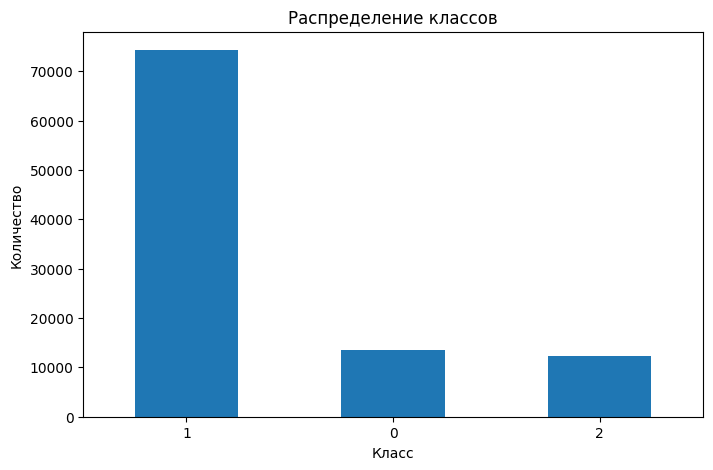

In [ ]:
# Строим гистограмму целевой переменной 'strength'
plt.figure(figsize=(8, 5))
data['strength'].value_counts().plot(kind='bar')
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.xticks(ticks=[0,1,2], labels=[1,0,2], rotation=0)
# Показываем график
plt.show()

In [ ]:
data['strength'].value_counts()

,count
strength,
1,74278
0,13428
2,12294


Наблюдается сильный дисбаланс с перевесом в пользу класса средних паролей, далее будет необходимо сбалансировать наш датасет.
#Создаем новый датасет, в котором хранится следующая информация о паролях:
1. Длина пароля
2. Количество заглавных букв
3. Количество строчных букв
4. Количество специальных символов
5. Количество цифр
6. Максимальное количество подряд идущих символов одной категориии
7. Отношение количества уникальных символов к длине пароля
8. Является пароль популярным или нет

In [ ]:
new_data = add_features(data)
print('Новый датасет')
print(new_data.head(),'\n')

Новый датасет
           password  strength  length  special_chars  uppercase  lowercase  \
0        yrtzuab476         1      10              0          0          7   
1  yEdnN9jc1NgzkkBP         2      16              0          5          9   
2          sarita99         1       8              0          0          6   
3    Suramerica2015         2      14              0          1          9   
4  PPRbMvDIxMQ19TMo         2      16              0         10          4   

   digits  max_consecutive  uniq_chars_%  pass_is_popular?  
0       3                7      1.000000                 0  
1       2                4      0.875000                 0  
2       2                6      0.750000                 1  
3       4                9      0.857143                 0  
4       2                3      0.812500                 0   



Посмотрим какие из наших паролей являются популярными

In [ ]:
new_data[new_data['pass_is_popular?']==1]['password']

,password
2,sarita99
5,yuri2011
8,amormio123
17,kristian1997
20,jlaudiow7
...,...
99984,neha16
99986,jdt12345
99987,niggers1
99994,ha63ma72


Оказалось, что около 20% датасета являются "шаблонными"

# Тепловая карта
Построение тепловой карты для проверки корреляции

.corr() используется для поиска попарной корреляции всех столбцов в кадре данных.


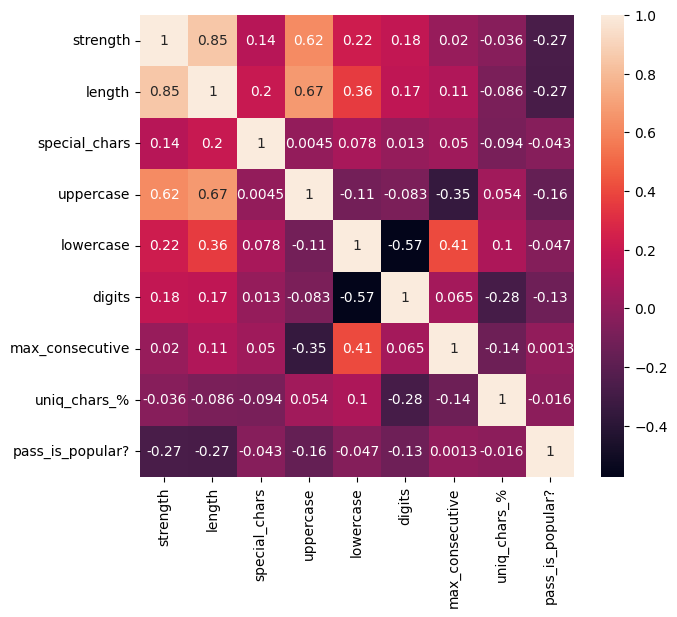

In [ ]:
plt.figure(figsize=(7,6))
sns.heatmap(new_data.corr(numeric_only = True,method='pearson'), annot=True)
plt.show()

Наиболее коррелирующим с целевым признаком является длина пароля. Максимальное количество подряд идущих символов одной категориии и отношение количества уникальных символов к длине пароля являются признаками, наименее коррелирующими с целевым признаком.

#Решаем проблему дисбаланса с помощью метода SMOTE и RandomUnderSampler. Разделяем полученный датасет на тестовую и тренировочную выборки.


In [ ]:
# Выбираем следующие классификаторы:
tuned_classifiers = {
    "LogisiticRegression": LogisticRegression(random_state=42),
    "KNearest": KNeighborsClassifier(n_neighbors=5),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    "Support Vector Classifier": SVC()
}

In [ ]:
# Определяем признаки и целевую переменную из несбалансированного набора данных
X = new_data[['length','uppercase']]  # Признаки (все столбцы кроме целевой переменной)
y = new_data['strength']  # Целевая переменная

original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2,
                                                                                    random_state = 42)
# Используем StratifiedKFold для обеспечения стратифицированной кросс-валидации
# Это объект кросс-валидации, который позволяет сохранить процент образцов для каждого класса в каждом фоне.
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)  # 5 образцов для кросс-валидации

# Создаем объект для уменьшения выборки для большинства
under = RandomUnderSampler()

#Выбираем наилучшую модель для классификации

In [ ]:
import time
# Итерируемся по словарю с настроенными классификаторами
for key, classifier in tuned_classifiers.items():
    time1 = time.time()
    # Создаем список шагов для пайплайна машинного обучения
    steps = [ ('u', under), ('model', classifier)]  # Шаги: увеличенная выборка, уменьшенная выборка и модель

    # Создаем пайплайн машинного обучения
    FiPipeline = Pipeline(steps=steps)  # Инициализация пайплайна с указанными шагами

    # Кросс-валидация классификаторов с использованием определенного пайплайна
    scores = cross_val_score(FiPipeline, original_Xtrain, original_ytrain, cv=sss)  # Оценка модели с помощью кросс-валидации
    time2 = time.time()
    # Выводим средний коэффициент точности
    print(f"Название: {key}, оценка точности: {round(scores.mean() * 100, 2)} %, время обучения : {(time2-time1):0.2f} секунд")  # Печать результатов


Название: LogisiticRegression, оценка точности: 99.99 %, время обучения : 1.50 секунд
Название: KNearest, оценка точности: 99.96 %, время обучения : 6.82 секунд
Название: DecisionTreeClassifier, оценка точности: 100.0 %, время обучения : 0.28 секунд
Название: Support Vector Classifier, оценка точности: 99.98 %, время обучения : 3.72 секунд


Все модели показали прекрасный результат! Обучим модель DecisionTreeClassifier.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2669
           1       1.00      1.00      1.00     14878
           2       1.00      1.00      1.00      2453

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



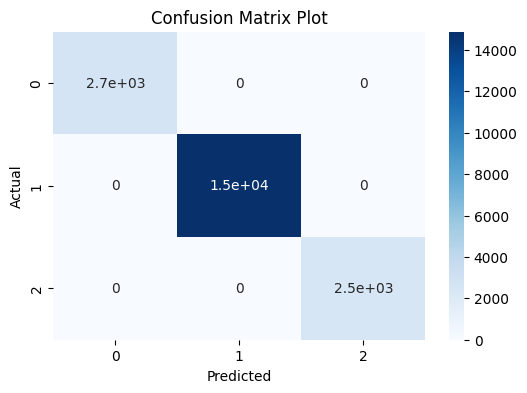

In [ ]:
# Создание модели
model = Pipeline([
    ('u', RandomUnderSampler()),  # Шаг для уменьшения выборки большинства
    ('classification', DecisionTreeClassifier()) ])

model.fit(original_Xtrain, original_ytrain)  # Обучаем модель
prediction = model.predict(original_Xtest)

# Вывод метрик
labels = ['0', '1','2']
print(classification_report(original_ytest, prediction, target_names=labels))

conf_matrix = confusion_matrix(original_ytest, prediction)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Plot")
plt.show()


Модель идеально работает, нет ни единой ошибки в определении сложности пароля. (спасибо за это датасету от Сбера)

#Последним способом попробуем реализовать задачу NLP.

In [ ]:
# Разделение данных
X = data['password']
y = data['strength']

# Токенизация паролей
tokenizer = Tokenizer(char_level=True)  # Работа с символами
tokenizer.fit_on_texts(X)

X_sequences = tokenizer.texts_to_sequences(X)

# Все пароли в виде списков чисел добиваем до длины max_length
max_length = max(len(seq) for seq in X_sequences)
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding='post')

# Преобразуем метки
y_categorical = to_categorical(y, num_classes=3)
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

0              yrtzuab476
1        yEdnN9jc1NgzkkBP
2                sarita99
3          Suramerica2015
4        PPRbMvDIxMQ19TMo
               ...       
99995           aulona044
99996         5201314ding
99997          isaac19725
99998              toji25
99999         midnight000
Name: password, Length: 100000, dtype: object


# Определим модель

In [ ]:
def create_model(tokenizer,max_length):

    # Создаем модель
    model = Sequential([
      Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64),
      LSTM(64, return_sequences=True), # рекуррентная нейронная сеть, выход 64 нейрона
      Dropout(0.5), # отбрасываем половину нейронов, исключаем переобучение
      LSTM(32), #  возвращаем только выходные данные для последнего временного шага
      Dropout(0.5),
      Dense(3, activation='softmax') # полносвязный слой, 3 - количество нейронов (равно кол-ву наших классов)
      ])
    # подготавливаем модель к обучению
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

#Обучим модель




In [ ]:
model = create_model(tokenizer,max_length)
# Обучаем модель
model.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.2)

Epoch 1/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 104s 50ms/step - accuracy: 0.9094 - loss: 0.2747 - val_accuracy: 0.9998 - val_loss: 0.0019
Epoch 2/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 140s 49ms/step - accuracy: 0.9944 - loss: 0.0202 - val_accuracy: 0.9999 - val_loss: 5.0774e-04
Epoch 3/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 145s 51ms/step - accuracy: 0.9941 - loss: 0.0202 - val_accuracy: 0.9999 - val_loss: 3.5865e-04


Наблюдаем отличный результат!

In [ ]:
# Прогнозирование
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2669
           1       1.00      1.00      1.00     14878
           2       1.00      1.00      1.00      2453

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



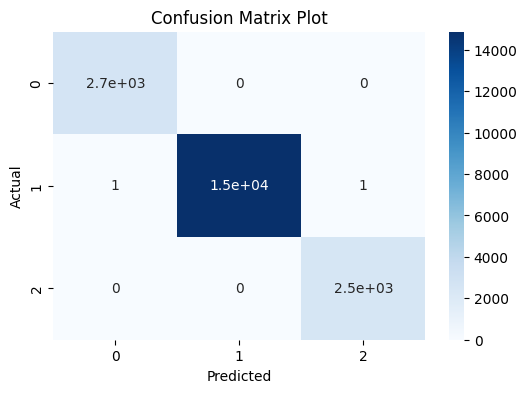

In [ ]:
print(classification_report(y_true, y_pred))

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Plot")
plt.show()

В итоге, получаем идеальную модель как и в первом случае.


